In [1]:
import numpy as np
import os
import pandas as pd 
import matplotlib.pyplot as plt

os.chdir('/Users/matthiasboeker/Desktop/Master_Thesis/Schizophrenia_Depression_Project')
from Modules.support_functions import *

In [25]:
#Import Schizophrenia data
os.chdir('/Users/matthiasboeker/Desktop/Master_Thesis/Schizophrenia_Depression_Project/Data/psykose/patient')
files = os.listdir()
files.sort(key=natural_keys)
shizophrenia_p = list()
for i in range(0,len(files)):
    if files[i].endswith('.csv'):
        shizophrenia_p.append(pd.read_csv(files[i]))
    
os.chdir('/Users/matthiasboeker/Desktop/Master_Thesis/Schizophrenia_Depression_Project/Data/psykose/control')
files = os.listdir()
files.sort(key=natural_keys)
shizophrenia_c = list()
for i in range(0,len(files)):
    if files[i].endswith('.csv'):
        shizophrenia_c.append(pd.read_csv(files[i]))
#Import demographics on Schizophrenia patients
os.chdir('/Users/matthiasboeker/Desktop/Master_Thesis/Schizophrenia_Depression_Project/Data/psykose')
patients_info = pd.read_csv('patients_info.csv')
#Import demographics on control group 
control_info = pd.read_csv('scores.csv')
#Import days 
days = pd.read_csv('days.csv')
shizophrenia_p, shizophrenia_c = preprocess(days,shizophrenia_p, shizophrenia_c)

## Gaussian Filter

In [13]:
from scipy.ndimage import gaussian_filter
from statsmodels.tsa.stattools import adfuller, kpss
#gauss_filt = pd.Series(gaussian_filter(shizophrenia_p[1], sigma=1))
gauss_filt = pd.Series(gaussian_filter(shizophrenia_p[1], sigma=10))
gauss_filtc = pd.Series(gaussian_filter(shizophrenia_c[1], sigma=10))


In [34]:
adfTest = adfuller(shizophrenia_c[10], autolag='AIC')
kpss = kpss_test(shizophrenia_c[10].values)

Results of KPSS Test:
Test Statistic            0.172832
p-value                   0.100000
Lags Used                71.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1742: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn(warn_msg.format(direction="greater"), InterpolationWarning)


In [35]:
print('AdFuller pValue: ',adfTest[1])
print('KPSS pValue: ',kpss[1])

AdFuller pValue:  4.388915883099255e-28


TypeError: 'NoneType' object is not subscriptable

In [29]:
shizophrenia_c[4].values

array([   0,    3,    3, ..., 1010,  328,  550])

Text(0.5,1,'Control')

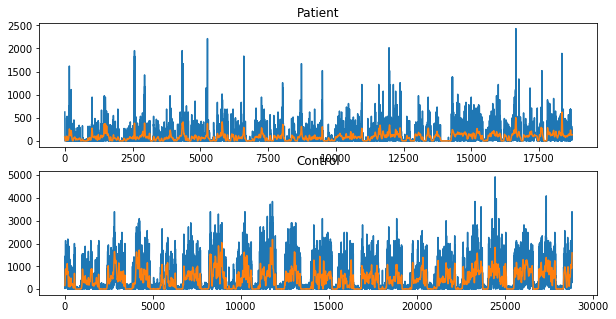

In [16]:
fig, (ax0,ax1) = plt.subplots(2, 1, figsize=(10, 5))
ax0.plot(shizophrenia_p[1])
ax0.plot(gauss_filt)
ax0.set_title('Patient')
ax1.plot(shizophrenia_c[1])
ax1.plot(gauss_filtc)
ax1.set_title('Control')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(shizophrenia_p[1].index,shizophrenia_p[1], marker='.')
ax.scatter(gauss_filt.index,gauss_filt, marker='.')

## Fourier Transformation

In [32]:
from scipy.fft import fft, ifft
from scipy.fft import fftfreq

trans_fft = fft(shizophrenia_p[1])
trans_psd = np.log(np.abs(trans_fft))
freq = fftfreq(len(shizophrenia_p[1]),(1. / 32))
i = freq > 0

Text(0,0.5,'PSD (dB)')

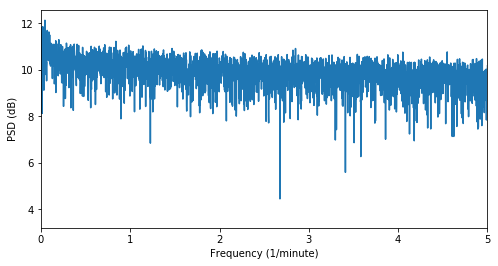

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(freq[i], 10 * np.log10(trans_psd[i])**2)
ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/minute)')
ax.set_ylabel('PSD (dB)')

In [34]:
max_peak = freq[np.argmax( trans_psd[i])]
print(max_peak)


0.042735042735042736


In [35]:
trans_fft_bis = trans_fft.copy()
trans_fft_bis[np.abs(freq) > max_peak] = 0

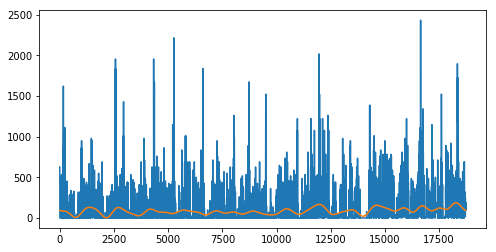

In [113]:
back = pd.Series(np.real(ifft(trans_fft_bis)))
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(shizophrenia_p[1])
ax.plot(back)


## Use Gaussian Mixture model of fft to identify hidden states

Gaussian Filter has a lower AIC and BIC 


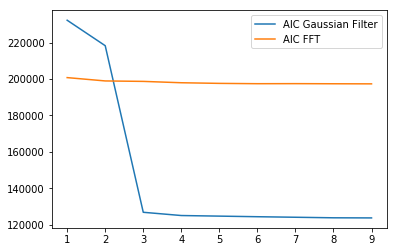

In [79]:
import sklearn.mixture as mix

n_components = range(1, 10)
models = [mix.GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics_g = [model.fit(np.array(gauss_filt).reshape(-1, 1)).aic(np.array(gauss_filt).reshape(-1, 1)) for model in models]
#bics_g = [model.fit(np.array(gauss_filt).reshape(-1, 1)).bic(np.array(gauss_filt).reshape(-1, 1)) for model in models]
aics_fft = [model.fit(np.array(gauss_filt1).reshape(-1, 1)).aic(np.array(gauss_filt1).reshape(-1, 1)) for model in models]
#bics_fft = [model.fit(np.array(gauss_filt1).reshape(-1, 1)).bic(np.array(gauss_filt1).reshape(-1, 1)) for model in models]
plt.plot(n_components, aics_g, label='AIC Gaussian Filter')
#plt.plot(n_components, bics_g, label = 'BIC Gaussian Filter')
plt.plot(n_components, aics_fft, label='AIC FFT')
#plt.plot(n_components, bics_fft, label = 'BIC FFT')
plt.legend()
print('Gaussian Filter has a lower AIC and BIC ')

In [ ]:
#How to determine the parameter d when reshaping the time series to matrix=
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(tt)
plot_pacf(tt)

### Gaussian Mixture Model of the Gaussian filtered Series

In [138]:
# remodel the time series to matrix 
tt = shizophrenia_p[1]
gt = pd.Series(gauss_filt)
# How to determine a ? 
a = 5
binn = list()
for i in range(0,len(gt)-a):
    row = gt.iloc[i:i+a]
    binn.append(row)
matrix = np.array(binn)


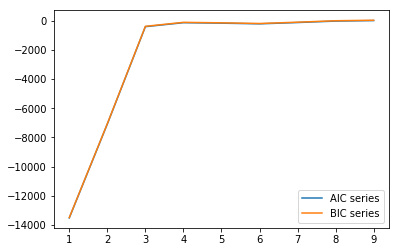

In [175]:
import sklearn.mixture as mix

n_components = range(1, 10)
models = [mix.GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics_s = [model.fit(np.array(gauss_filt).reshape(-1, 1)).aic(np.array(gauss_filt).reshape(-1, 1)) for model in models]
bics_s = [model.fit(np.array(gauss_filt).reshape(-1, 1)).bic(np.array(gauss_filt).reshape(-1, 1)) for model in models]
plt.plot(n_components, np.gradient(aics_s), label='AIC series')
plt.plot(n_components, np.gradient(bics_s), label = 'BIC series')
plt.legend()
#print('Gaussian Filter has a lower AIC and BIC ')

In [80]:
tt = shizophrenia_p[10]
gauss_filt = pd.Series(gaussian_filter(shizophrenia_p[10], sigma=10))
matrix=np.array(gauss_filt)[np.arange(10)+ np.arange(np.max(gauss_filt.shape[0] - (10-1), 0)).reshape(-1,1)]

In [81]:
import sklearn.mixture as mix
model = mix.BayesianGaussianMixture(n_components=3, covariance_type='full', 
                                     random_state=0, weight_concentration_prior=1e+2,max_iter=1000, 
                                     weight_concentration_prior_type='dirichlet_process',
                                   init_params="kmeans").fit(matrix)

print(model.converged_)
hidden_states = model.predict(matrix)
state_prob = model.predict_proba(matrix)
#print(model.fit(np.array(gauss_filt).reshape(-1, 1)).bic(np.array(gauss_filt).reshape(-1, 1)))

True


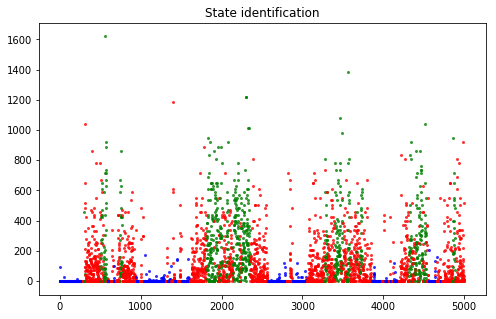

In [82]:
fig = plt.figure(figsize=(8,5))
color = ['darkorange' if x>2 else 'green' if x==2 else 'red'if x==1 else 'blue' for x in hidden_states[:5000]]
for x, l, c in zip(tt.index[:5000], tt[:5000], color):
    plt.scatter(x, l, alpha=0.8, c=c,marker='.', linewidths=0.01) 
    plt.title('State identification')
#plt.scatter(gt[:2500].index, gt[:2500], c='red', marker='.', linewidths=0.01, label = 'Gaussian Filtered Series')
#plt.plot(state_prob[:5000]*1000, label = 'State probabilty *1000')
#plt.legend(loc='upper right')

In [89]:
tt = shizophrenia_p[10]
gauss_filt = pd.Series(gaussian_filter(shizophrenia_p[10], sigma=10))

import sklearn.mixture as mix
model = mix.GaussianMixture(n_components=10, 
                            covariance_type="full", init_params="kmeans",
                            n_init=100, 
                            random_state=7).fit(np.array(gauss_filt).reshape(-1, 1))
print(model.converged_)
hidden_states = model.predict(np.array(gauss_filt).reshape(-1, 1))
state_prob = model.predict_proba(np.array(gauss_filt).reshape(-1, 1))

True


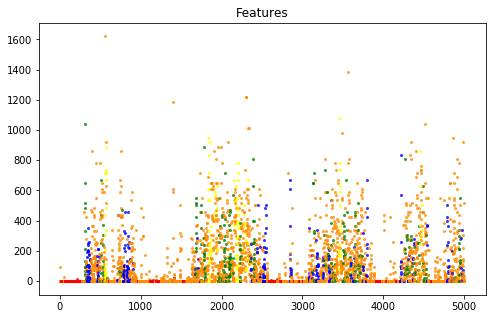

In [76]:
fig = plt.figure(figsize=(8,5))
color = ['darkorange' if x>4 else 'green' if x==3 else 'red' if x==2 else 'yellow' if x==1 else 'blue'for x in hidden_states[:5000]]
for x, l, c in zip(tt.index[:5000], tt[:5000], color):
    plt.scatter(x, l, alpha=0.8, c=c,marker='.', linewidths=0.01) 
    plt.title('Features')
#plt.scatter(gt[:2500].index, gt[:2500], c='red', marker='.', linewidths=0.01, label = 'Gaussian Filtered Series')
#plt.plot(state_prob[:5000]*1000, label = 'State probabilty *1000')
#plt.legend(loc='upper right')

In [90]:
model.covariances_

array([[[1.46023098e-01]],

       [[4.14470535e+02]],

       [[2.42198973e+02]],

       [[1.62859009e+03]],

       [[3.02270741e+02]],

       [[6.03626888e+02]],

       [[7.07753295e+02]],

       [[3.98011402e+03]],

       [[2.68872339e+02]],

       [[1.98200647e+01]]])

In [94]:
np.sort(model.weights_)[::-1]

array([0.19435557, 0.17753027, 0.16135072, 0.14891147, 0.11009506,
       0.08279293, 0.06541004, 0.04000832, 0.01509132, 0.0044543 ])

In [92]:
model.means_

array([[1.77395076e-01],
       [2.07319428e+02],
       [9.61054371e+01],
       [3.52720449e+02],
       [1.61796772e+02],
       [4.98594649e+01],
       [2.66061552e+02],
       [5.26275949e+02],
       [1.33575456e+02],
       [6.23543702e+00]])

In [93]:
weights = np.sort(model.weights_)[::-1]
print(weights[:5])
print('Amount: ',np.sum(weights[:5]))

[0.19435557 0.17753027 0.16135072 0.14891147 0.11009506]
Amount:  0.7922430921088945
